In [1]:
import random
random.seed(666)

import math
import numpy as np
import pandas as pd
import logging

import torch
from torch import nn
from torch.nn import functional as F
torch.manual_seed(666)

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score 

from platform import python_version
print(python_version())
print(torch.__version__)

3.8.15
1.12.1+cu113


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu") 
print(device)

cuda:0


Helper functions

In [4]:
def flatten_for_auc(xss):
    return [x.cpu().detach().numpy() for xs in xss for x in xs]

def flatten_for_acc(xss):
    return [x.cpu().detach().numpy().argmax() for xs in xss for x in xs]

Load neural data

In [9]:
# Load KS sorted data
ks_spike_times = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/sorted/pykilosort/spikes.times.npy')
ks_spike_clusters = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/sorted/pykilosort/spikes.clusters.npy')
n_neurons = len(np.unique(ks_spike_clusters))

# Load our unsorted data
spike_indices = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/unsorted/spike_indices.npy')
spike_features = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/unsorted/spike_features.npy')
n_channels = 384

start_movement_times = np.load("drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/alf/_ibl_trials.firstMovement_times.npy")
np1_channel_map = np.load('drive/MyDrive/Neural/ibl/np1_channel_map.npy')
behavior_tasks = np.load('drive/MyDrive/Neural/ibl/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_danlab_DY_016/hyun_behaviors/d23a44ef-1402-4ed7-97f5-47e9a7a504d9_feature.npy')
choices = behavior_tasks[:,:,:,22:24].sum(2)[0,:,:]
n_trials = start_movement_times.shape[0]

Pre-process sorted data

In [10]:
ks_data = np.concatenate([ks_spike_times.reshape(-1,1), ks_spike_clusters.reshape(-1,1)], axis=1)
sorted_trials = []
for n in range(n_trials):
    trial = ks_data[(ks_data[:,0]*30003.0003 >= start_movement_times[n]-30003.0003*0.5) & (ks_data[:,0]*30003.0003 <= start_movement_times[n]+30003.0003),:]
    trial[:,0] = (trial[:,0] - trial[:,0].min()) 
    sorted_trials.append(trial)

In [11]:
n_time_bins = 30
t_bins = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)

# Unnormalized firing rates
sorted_firing_rates = []
for n in range(n_trials):
    rows = (sorted_trials[n])[:,1].astype(int)
    columns = np.digitize(sorted_trials[n][:,0], t_bins, right=False)-1                           # Use same time binning for all trials
    # columns = pd.qcut((trials[n])[:,0], n_time_bins, list(np.arange(n_time_bins))).to_numpy()   # Use diff time binning for each trial
    firing_rates = np.zeros([n_neurons, n_time_bins])
    np.add.at(firing_rates, (rows, columns), 1) 
    sorted_firing_rates.append(firing_rates)

sorted_firing_rates = np.array(sorted_firing_rates)
print(sorted_firing_rates.shape)

(286, 514, 30)


In [12]:
# # Check time binnings
t_bins = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
np.digitize(sorted_trials[0][:,0], t_bins, right=False)-1

array([ 0,  0,  0, ..., 29, 29, 29])

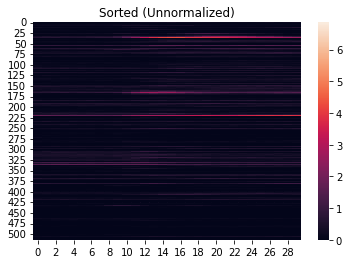

In [13]:
sns.heatmap(sorted_firing_rates.mean(0))
plt.title('Sorted (Unnormalized)'.format(sorted_firing_rates.shape[1]));
plt.show()

In [14]:
# Normalized firing rates 
norm_sorted_firing_rates = sorted_firing_rates.copy().reshape(-1, n_neurons*n_time_bins)
for k in range(n_time_bins):
  norm_sorted_firing_rates[:, k*n_neurons:(k+1)*n_neurons] = \
  (norm_sorted_firing_rates[:, k*n_neurons:(k+1)*n_neurons] - norm_sorted_firing_rates[:, k*n_neurons:(k+1)*n_neurons].mean()) \
  / norm_sorted_firing_rates[:, k*n_neurons:(k+1)*n_neurons].std()
norm_sorted_firing_rates = norm_sorted_firing_rates.reshape(-1, n_neurons, n_time_bins)

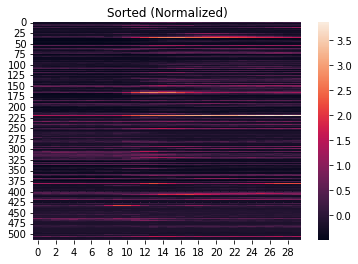

In [15]:
sns.heatmap(norm_sorted_firing_rates.mean(0))
plt.title('Sorted (Normalized)'.format(norm_sorted_firing_rates.shape[1]));
plt.show()

Load Unsorted Data

In [16]:
unsorted_data = np.concatenate([spike_indices[:,0].reshape(-1,1), spike_indices[:,1].reshape(-1,1), spike_features[:,[0,2,4]]], axis = 1)
unsorted_trials = []
for n in range(n_trials):
    trial = unsorted_data[(unsorted_data[:,0] >= start_movement_times[n]-30003.0003*0.5) & (unsorted_data[:,0] <= start_movement_times[n]+30003.0003),:2]
    trial[:,0] = (trial[:,0] - trial[:,0].min()) / 30003.0003
    unsorted_trials.append(trial)

In [17]:
# Check time range
start = min([seq[0, 0]  for seq in unsorted_trials])
end   = max([seq[-1, 0] for seq in unsorted_trials])
print(start)
print(end)

0.0
1.4999499900014999


In [18]:
n_time_bins = 30
t_bins = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)

unsorted_firing_rates = []
for n in range(n_trials):
    rows = (unsorted_trials[n])[:,1].astype(int)
    columns = np.digitize(unsorted_trials[n][:,0], t_bins, right=False)-1                        # Use same time binning for all trials
    # columns = pd.qcut((trials[n])[:,0], n_time_bins, list(np.arange(n_time_bins))).to_numpy()  # Use diff time binning for each trial
    firing_rates = np.zeros([n_channels, n_time_bins])
    np.add.at(firing_rates, (rows, columns), 1) 
    unsorted_firing_rates.append(firing_rates)

unsorted_firing_rates = np.array(unsorted_firing_rates)
print(unsorted_firing_rates.shape)

(286, 384, 30)


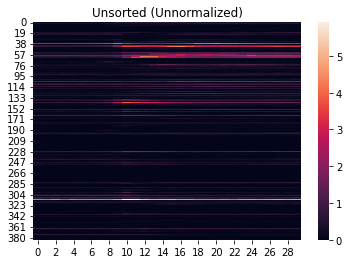

In [19]:
sns.heatmap(unsorted_firing_rates.mean(0))
plt.title('Unsorted (Unnormalized)'.format(unsorted_firing_rates.shape[1]));
plt.show()

In [20]:
norm_unsorted_firing_rates = unsorted_firing_rates.copy().reshape(-1, n_channels*n_time_bins)
for k in range(n_time_bins):
  norm_unsorted_firing_rates[:, k*n_channels:(k+1)*n_channels] = \
  (norm_unsorted_firing_rates[:, k*n_channels:(k+1)*n_channels] - norm_unsorted_firing_rates[:, k*n_channels:(k+1)*n_channels].mean()) \
  / norm_unsorted_firing_rates[:, k*n_channels:(k+1)*n_channels].std()
norm_unsorted_firing_rates = norm_unsorted_firing_rates.reshape(-1, n_channels, n_time_bins)

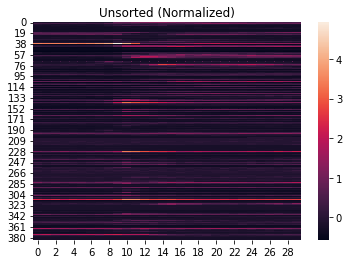

In [21]:
sns.heatmap(norm_unsorted_firing_rates.mean(0))
plt.title('Unsorted (Normalized)'.format(norm_unsorted_firing_rates.shape[1]));
plt.show()

Define Model

In [22]:
class Decoder(nn.Module):
    def __init__(self, config, device):
        super(Decoder, self).__init__()
        self.config = config
        self.device = device

        if config.data_type == 'sorted':
            n_units = n_neurons
        else:
            n_units = n_channels
        
        decoder_layers = []
        decoder_layers.append(nn.Flatten(1))
        decoder_layers.append(nn.Linear(n_units*n_time_bins, config.hid_dim))
        decoder_layers.append(nn.BatchNorm1d(config.hid_dim)) 
        decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Dropout(config.drop_out))
        decoder_layers.append(nn.Linear(config.hid_dim, 2))

        self.decoder = nn.Sequential(*decoder_layers)
        self.softmax = nn.Softmax(dim=1)
                
        self.optimizer = self.set_optimizer(config.opt, config.lr, config.momentum)
        self.to(device)


    def loss(self, batch_data, batch_labels):
        batch_preds = self(batch_data)    
        criterion = nn.CrossEntropyLoss()
        batch_loss = criterion(batch_preds, batch_labels)
        return batch_loss
   
    
    def forward(self, batch_data):        
        batch_preds = self.decoder(batch_data)
        batch_preds = self.softmax(batch_preds)
        return batch_preds
  
    
    def set_optimizer(self, opt, lr, momentum):
        if opt == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum, weight_decay=config.weight_decay) # L2-Regularization
        elif opt == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=lr)

In [23]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def eval_loss(model, test_loader, device):
    model.eval()
    loss_total = 0
    loss_meter = AverageMeter()
    auc_meter = AverageMeter()
    acc_meter = AverageMeter()
    
    for index, batch in enumerate(test_loader):
        batch_data, batch_labels = map(lambda x: cast(x, device), batch)
        y_true = batch_labels.cpu().detach().numpy()
        y_pred = model(batch_data).cpu().detach().numpy()
        loss = model.loss(batch_data, batch_labels)
        loss_meter.update(loss.item())
        auc = np.infty
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        auc_meter.update(auc)
        acc = accuracy_score(y_true.argmax(1), y_pred.argmax(1))
        acc_meter.update(acc)
        
    return loss_meter.avg, auc_meter.avg, acc_meter.avg

In [24]:
def train(model, train_loader, val_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=50, gamma=0.1)
    best_eval = np.infty
    loss_meter = AverageMeter()

    train_losses = []
    val_losses = []
    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, batch in tenumerate(train_loader):
            batch_data, batch_labels = map(lambda x: cast(x, device), batch)

            model.optimizer.zero_grad()
            loss = model.loss(batch_data, batch_labels)

            if torch.isnan(loss):
                print("Numerical error, quiting...")
                return model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip)
            model.optimizer.step()

            loss_meter.update(loss.item())

        scheduler.step()

        logger.info("In epochs {} | "
                    "total loss: {:5f}".format(
            epoch, loss_meter.avg
        ))
        if (epoch+1)%config.eval_epoch==0:
            train_loss, train_auc, train_acc = eval_loss(model, train_loader, device)
            val_loss, val_auc, val_acc = eval_loss(model, val_loader, device)
            logger.info("Val Loss {:5f} Val AUC {:5f} Val Acc {:5f}".format(val_loss, val_auc, val_acc))
            train_losses.append([[train_loss],[train_auc],[train_acc]])
            val_losses.append([[val_loss],[val_auc],[val_acc]])

    print("Training done!")
    val_losses = np.asarray(val_losses)
    train_losses = np.asarray(train_losses) 
    return train_losses, val_losses

In [25]:
def reset_weights(model):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

Model Training

In [26]:
data_type = 'sorted'
# data_type = 'unsorted'

In [40]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = Namespace(data_type=data_type, hid_dim = 128,
                   lr=1e-4, momentum=0.9, weight_decay=1e-6,
                   epochs=50, batch=32, opt='Adam', 
                   eval_epoch=1, drop_out=0.1, clip=1e7)

In [28]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, train_set, test_set, train, train_labels, test_labels):

        self.dataset = [torch.tensor(data) for data in (train_set if train else test_set)]
        
        self.labels = [torch.tensor(label) for label in (train_labels if train else test_labels)]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index], self.labels[index]

In [29]:
class NeuralData(Dataset):
        def __init__(self, data_type=None, split="train", train_ids=None, val_ids=None, test_ids=None):
            if data_type == 'sorted':
                neural_data = norm_sorted_firing_rates
            else:
                neural_data = norm_unsorted_firing_rates

            assert split in ["train", "val", "test"]
            self.split = split
            data_splits = {"train": train_ids, "val": val_ids, "test": test_ids}
            train_set = [neural_data[idx] for idx in train_ids]
            split_set = [neural_data[idx] for idx in data_splits[split]]
            train_labels = [choices[idx] for idx in train_ids]
            split_labels = [choices[idx] for idx in data_splits[split]]
            super().__init__(train_set, split_set, split == "train", train_labels, split_labels)

        def extra_repr(self):
            return f"Split: {self.split}"

In [30]:
# Prepare logger
logger = logging.getLogger('batch{}'.format(config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('batch{}.log'.format(config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [31]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
def cast(tensor, device):
    return tensor.float().to(device)

In [33]:
trial_ids = np.arange(286)
random.shuffle(trial_ids)

In [34]:
train_ids = trial_ids[:228]
val_ids = trial_ids[228:257]
test_ids = trial_ids[257:]

In [35]:
train_set = NeuralData(data_type=config.data_type, split="train", train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)
val_set = NeuralData(data_type=config.data_type, split="val", train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)
test_set = NeuralData(data_type=config.data_type, split="test", train_ids=train_ids, val_ids=val_ids, test_ids=test_ids)

In [36]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=32,
    shuffle=False
)

In [41]:
model = Decoder(config, device)
model.apply(reset_weights)

Reset trainable parameters of layer = Linear(in_features=15420, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


Decoder(
  (decoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=15420, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [42]:
sum([param.nelement() for param in model.parameters()])

1974402

In [43]:
train_losses, val_losses = train(model, train_loader, val_loader, config, logger, device)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:18,914 INFO In epochs 0 | total loss: 0.674627
INFO:batch32:In epochs 0 | total loss: 0.674627
2022-12-04 19:35:18,975 INFO Val Loss 0.648553 Val AUC 0.798701 Val Acc 0.655172
INFO:batch32:Val Loss 0.648553 Val AUC 0.798701 Val Acc 0.655172


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:19,125 INFO In epochs 1 | total loss: 0.642453
INFO:batch32:In epochs 1 | total loss: 0.642453
2022-12-04 19:35:19,182 INFO Val Loss 0.625681 Val AUC 0.889610 Val Acc 0.758621
INFO:batch32:Val Loss 0.625681 Val AUC 0.889610 Val Acc 0.758621


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:19,374 INFO In epochs 2 | total loss: 0.612833
INFO:batch32:In epochs 2 | total loss: 0.612833
2022-12-04 19:35:19,441 INFO Val Loss 0.612824 Val AUC 0.915584 Val Acc 0.793103
INFO:batch32:Val Loss 0.612824 Val AUC 0.915584 Val Acc 0.793103


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:19,589 INFO In epochs 3 | total loss: 0.588537
INFO:batch32:In epochs 3 | total loss: 0.588537
2022-12-04 19:35:19,685 INFO Val Loss 0.598800 Val AUC 0.915584 Val Acc 0.862069
INFO:batch32:Val Loss 0.598800 Val AUC 0.915584 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:19,835 INFO In epochs 4 | total loss: 0.570517
INFO:batch32:In epochs 4 | total loss: 0.570517
2022-12-04 19:35:19,903 INFO Val Loss 0.575650 Val AUC 0.922078 Val Acc 0.862069
INFO:batch32:Val Loss 0.575650 Val AUC 0.922078 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:20,060 INFO In epochs 5 | total loss: 0.556474
INFO:batch32:In epochs 5 | total loss: 0.556474
2022-12-04 19:35:20,126 INFO Val Loss 0.579506 Val AUC 0.928571 Val Acc 0.862069
INFO:batch32:Val Loss 0.579506 Val AUC 0.928571 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:20,244 INFO In epochs 6 | total loss: 0.542271
INFO:batch32:In epochs 6 | total loss: 0.542271
2022-12-04 19:35:20,318 INFO Val Loss 0.575866 Val AUC 0.954545 Val Acc 0.862069
INFO:batch32:Val Loss 0.575866 Val AUC 0.954545 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:20,511 INFO In epochs 7 | total loss: 0.533237
INFO:batch32:In epochs 7 | total loss: 0.533237
2022-12-04 19:35:20,572 INFO Val Loss 0.579238 Val AUC 0.961039 Val Acc 0.827586
INFO:batch32:Val Loss 0.579238 Val AUC 0.961039 Val Acc 0.827586


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:20,740 INFO In epochs 8 | total loss: 0.522742
INFO:batch32:In epochs 8 | total loss: 0.522742
2022-12-04 19:35:20,803 INFO Val Loss 0.565504 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.565504 Val AUC 0.967532 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:21,005 INFO In epochs 9 | total loss: 0.516130
INFO:batch32:In epochs 9 | total loss: 0.516130
2022-12-04 19:35:21,066 INFO Val Loss 0.565990 Val AUC 0.967532 Val Acc 0.827586
INFO:batch32:Val Loss 0.565990 Val AUC 0.967532 Val Acc 0.827586


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:21,261 INFO In epochs 10 | total loss: 0.509919
INFO:batch32:In epochs 10 | total loss: 0.509919
2022-12-04 19:35:21,391 INFO Val Loss 0.569374 Val AUC 0.961039 Val Acc 0.793103
INFO:batch32:Val Loss 0.569374 Val AUC 0.961039 Val Acc 0.793103


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:21,570 INFO In epochs 11 | total loss: 0.501850
INFO:batch32:In epochs 11 | total loss: 0.501850
2022-12-04 19:35:21,638 INFO Val Loss 0.557402 Val AUC 0.954545 Val Acc 0.827586
INFO:batch32:Val Loss 0.557402 Val AUC 0.954545 Val Acc 0.827586


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:21,775 INFO In epochs 12 | total loss: 0.494823
INFO:batch32:In epochs 12 | total loss: 0.494823
2022-12-04 19:35:21,852 INFO Val Loss 0.541506 Val AUC 0.941558 Val Acc 0.862069
INFO:batch32:Val Loss 0.541506 Val AUC 0.941558 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:22,028 INFO In epochs 13 | total loss: 0.488254
INFO:batch32:In epochs 13 | total loss: 0.488254
2022-12-04 19:35:22,090 INFO Val Loss 0.543813 Val AUC 0.954545 Val Acc 0.862069
INFO:batch32:Val Loss 0.543813 Val AUC 0.954545 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:22,235 INFO In epochs 14 | total loss: 0.482367
INFO:batch32:In epochs 14 | total loss: 0.482367
2022-12-04 19:35:22,294 INFO Val Loss 0.539275 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.539275 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:22,447 INFO In epochs 15 | total loss: 0.476989
INFO:batch32:In epochs 15 | total loss: 0.476989
2022-12-04 19:35:22,548 INFO Val Loss 0.541018 Val AUC 0.954545 Val Acc 0.862069
INFO:batch32:Val Loss 0.541018 Val AUC 0.954545 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:22,687 INFO In epochs 16 | total loss: 0.471989
INFO:batch32:In epochs 16 | total loss: 0.471989
2022-12-04 19:35:22,759 INFO Val Loss 0.538324 Val AUC 0.948052 Val Acc 0.862069
INFO:batch32:Val Loss 0.538324 Val AUC 0.948052 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:22,906 INFO In epochs 17 | total loss: 0.468806
INFO:batch32:In epochs 17 | total loss: 0.468806
2022-12-04 19:35:22,976 INFO Val Loss 0.548811 Val AUC 0.961039 Val Acc 0.827586
INFO:batch32:Val Loss 0.548811 Val AUC 0.961039 Val Acc 0.827586


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:23,116 INFO In epochs 18 | total loss: 0.464258
INFO:batch32:In epochs 18 | total loss: 0.464258
2022-12-04 19:35:23,173 INFO Val Loss 0.539109 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.539109 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:23,349 INFO In epochs 19 | total loss: 0.461369
INFO:batch32:In epochs 19 | total loss: 0.461369
2022-12-04 19:35:23,426 INFO Val Loss 0.543228 Val AUC 0.961039 Val Acc 0.827586
INFO:batch32:Val Loss 0.543228 Val AUC 0.961039 Val Acc 0.827586


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:23,613 INFO In epochs 20 | total loss: 0.457645
INFO:batch32:In epochs 20 | total loss: 0.457645
2022-12-04 19:35:23,674 INFO Val Loss 0.534463 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.534463 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:23,821 INFO In epochs 21 | total loss: 0.453883
INFO:batch32:In epochs 21 | total loss: 0.453883
2022-12-04 19:35:23,882 INFO Val Loss 0.517998 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.517998 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:24,027 INFO In epochs 22 | total loss: 0.450554
INFO:batch32:In epochs 22 | total loss: 0.450554
2022-12-04 19:35:24,096 INFO Val Loss 0.520460 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.520460 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:24,236 INFO In epochs 23 | total loss: 0.448445
INFO:batch32:In epochs 23 | total loss: 0.448445
2022-12-04 19:35:24,325 INFO Val Loss 0.531853 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.531853 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:24,463 INFO In epochs 24 | total loss: 0.446394
INFO:batch32:In epochs 24 | total loss: 0.446394
2022-12-04 19:35:24,536 INFO Val Loss 0.533299 Val AUC 0.948052 Val Acc 0.862069
INFO:batch32:Val Loss 0.533299 Val AUC 0.948052 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:24,671 INFO In epochs 25 | total loss: 0.443452
INFO:batch32:In epochs 25 | total loss: 0.443452
2022-12-04 19:35:24,742 INFO Val Loss 0.523232 Val AUC 0.948052 Val Acc 0.862069
INFO:batch32:Val Loss 0.523232 Val AUC 0.948052 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:24,872 INFO In epochs 26 | total loss: 0.440672
INFO:batch32:In epochs 26 | total loss: 0.440672
2022-12-04 19:35:24,936 INFO Val Loss 0.519878 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.519878 Val AUC 0.961039 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:25,192 INFO In epochs 27 | total loss: 0.439170
INFO:batch32:In epochs 27 | total loss: 0.439170
2022-12-04 19:35:25,272 INFO Val Loss 0.530548 Val AUC 0.954545 Val Acc 0.862069
INFO:batch32:Val Loss 0.530548 Val AUC 0.954545 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:25,427 INFO In epochs 28 | total loss: 0.436669
INFO:batch32:In epochs 28 | total loss: 0.436669
2022-12-04 19:35:25,514 INFO Val Loss 0.521132 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.521132 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:25,687 INFO In epochs 29 | total loss: 0.435031
INFO:batch32:In epochs 29 | total loss: 0.435031
2022-12-04 19:35:25,756 INFO Val Loss 0.528386 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.528386 Val AUC 0.967532 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:25,957 INFO In epochs 30 | total loss: 0.432802
INFO:batch32:In epochs 30 | total loss: 0.432802
2022-12-04 19:35:26,015 INFO Val Loss 0.523027 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.523027 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:26,181 INFO In epochs 31 | total loss: 0.430682
INFO:batch32:In epochs 31 | total loss: 0.430682
2022-12-04 19:35:26,242 INFO Val Loss 0.520974 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.520974 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:26,431 INFO In epochs 32 | total loss: 0.429210
INFO:batch32:In epochs 32 | total loss: 0.429210
2022-12-04 19:35:26,528 INFO Val Loss 0.526559 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.526559 Val AUC 0.967532 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:26,708 INFO In epochs 33 | total loss: 0.427198
INFO:batch32:In epochs 33 | total loss: 0.427198
2022-12-04 19:35:26,828 INFO Val Loss 0.507974 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.507974 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:26,994 INFO In epochs 34 | total loss: 0.425936
INFO:batch32:In epochs 34 | total loss: 0.425936
2022-12-04 19:35:27,134 INFO Val Loss 0.518215 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.518215 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:27,244 INFO In epochs 35 | total loss: 0.424138
INFO:batch32:In epochs 35 | total loss: 0.424138
2022-12-04 19:35:27,383 INFO Val Loss 0.511931 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.511931 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:27,600 INFO In epochs 36 | total loss: 0.422275
INFO:batch32:In epochs 36 | total loss: 0.422275
2022-12-04 19:35:27,661 INFO Val Loss 0.500739 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.500739 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:27,813 INFO In epochs 37 | total loss: 0.421238
INFO:batch32:In epochs 37 | total loss: 0.421238
2022-12-04 19:35:27,891 INFO Val Loss 0.513092 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.513092 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:28,057 INFO In epochs 38 | total loss: 0.419680
INFO:batch32:In epochs 38 | total loss: 0.419680
2022-12-04 19:35:28,139 INFO Val Loss 0.500449 Val AUC 0.954545 Val Acc 0.931034
INFO:batch32:Val Loss 0.500449 Val AUC 0.954545 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:28,330 INFO In epochs 39 | total loss: 0.418786
INFO:batch32:In epochs 39 | total loss: 0.418786
2022-12-04 19:35:28,450 INFO Val Loss 0.511663 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.511663 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:28,625 INFO In epochs 40 | total loss: 0.417176
INFO:batch32:In epochs 40 | total loss: 0.417176
2022-12-04 19:35:28,747 INFO Val Loss 0.496364 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.496364 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:28,912 INFO In epochs 41 | total loss: 0.416423
INFO:batch32:In epochs 41 | total loss: 0.416423
2022-12-04 19:35:29,094 INFO Val Loss 0.504873 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.504873 Val AUC 0.967532 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:29,262 INFO In epochs 42 | total loss: 0.414984
INFO:batch32:In epochs 42 | total loss: 0.414984
2022-12-04 19:35:29,321 INFO Val Loss 0.502684 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.502684 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:29,416 INFO In epochs 43 | total loss: 0.413633
INFO:batch32:In epochs 43 | total loss: 0.413633
2022-12-04 19:35:29,474 INFO Val Loss 0.500479 Val AUC 0.967532 Val Acc 0.931034
INFO:batch32:Val Loss 0.500479 Val AUC 0.967532 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:29,560 INFO In epochs 44 | total loss: 0.412261
INFO:batch32:In epochs 44 | total loss: 0.412261
2022-12-04 19:35:29,605 INFO Val Loss 0.490576 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.490576 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:29,697 INFO In epochs 45 | total loss: 0.411543
INFO:batch32:In epochs 45 | total loss: 0.411543
2022-12-04 19:35:29,746 INFO Val Loss 0.503630 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.503630 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:29,833 INFO In epochs 46 | total loss: 0.410368
INFO:batch32:In epochs 46 | total loss: 0.410368
2022-12-04 19:35:29,881 INFO Val Loss 0.490609 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.490609 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:29,974 INFO In epochs 47 | total loss: 0.409699
INFO:batch32:In epochs 47 | total loss: 0.409699
2022-12-04 19:35:30,022 INFO Val Loss 0.503123 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.503123 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,111 INFO In epochs 48 | total loss: 0.409070
INFO:batch32:In epochs 48 | total loss: 0.409070
2022-12-04 19:35:30,167 INFO Val Loss 0.508710 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.508710 Val AUC 0.967532 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,258 INFO In epochs 49 | total loss: 0.407887
INFO:batch32:In epochs 49 | total loss: 0.407887
2022-12-04 19:35:30,310 INFO Val Loss 0.501940 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.501940 Val AUC 0.961039 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,400 INFO In epochs 50 | total loss: 0.406738
INFO:batch32:In epochs 50 | total loss: 0.406738
2022-12-04 19:35:30,445 INFO Val Loss 0.493334 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.493334 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,539 INFO In epochs 51 | total loss: 0.405634
INFO:batch32:In epochs 51 | total loss: 0.405634
2022-12-04 19:35:30,587 INFO Val Loss 0.495574 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.495574 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,675 INFO In epochs 52 | total loss: 0.404567
INFO:batch32:In epochs 52 | total loss: 0.404567
2022-12-04 19:35:30,727 INFO Val Loss 0.494579 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.494579 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,815 INFO In epochs 53 | total loss: 0.403569
INFO:batch32:In epochs 53 | total loss: 0.403569
2022-12-04 19:35:30,866 INFO Val Loss 0.490184 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.490184 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:30,956 INFO In epochs 54 | total loss: 0.403061
INFO:batch32:In epochs 54 | total loss: 0.403061
2022-12-04 19:35:31,001 INFO Val Loss 0.501703 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.501703 Val AUC 0.967532 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,089 INFO In epochs 55 | total loss: 0.402107
INFO:batch32:In epochs 55 | total loss: 0.402107
2022-12-04 19:35:31,139 INFO Val Loss 0.500888 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.500888 Val AUC 0.961039 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,233 INFO In epochs 56 | total loss: 0.401132
INFO:batch32:In epochs 56 | total loss: 0.401132
2022-12-04 19:35:31,285 INFO Val Loss 0.491603 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.491603 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,379 INFO In epochs 57 | total loss: 0.400192
INFO:batch32:In epochs 57 | total loss: 0.400192
2022-12-04 19:35:31,427 INFO Val Loss 0.489004 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.489004 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,533 INFO In epochs 58 | total loss: 0.399322
INFO:batch32:In epochs 58 | total loss: 0.399322
2022-12-04 19:35:31,586 INFO Val Loss 0.493771 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.493771 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,679 INFO In epochs 59 | total loss: 0.398921
INFO:batch32:In epochs 59 | total loss: 0.398921
2022-12-04 19:35:31,728 INFO Val Loss 0.504548 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.504548 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,825 INFO In epochs 60 | total loss: 0.398063
INFO:batch32:In epochs 60 | total loss: 0.398063
2022-12-04 19:35:31,874 INFO Val Loss 0.490629 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.490629 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:31,977 INFO In epochs 61 | total loss: 0.397655
INFO:batch32:In epochs 61 | total loss: 0.397655
2022-12-04 19:35:32,036 INFO Val Loss 0.503254 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.503254 Val AUC 0.961039 Val Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:32,142 INFO In epochs 62 | total loss: 0.397287
INFO:batch32:In epochs 62 | total loss: 0.397287
2022-12-04 19:35:32,192 INFO Val Loss 0.509006 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.509006 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:32,291 INFO In epochs 63 | total loss: 0.396535
INFO:batch32:In epochs 63 | total loss: 0.396535
2022-12-04 19:35:32,341 INFO Val Loss 0.502836 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.502836 Val AUC 0.961039 Val Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:32,443 INFO In epochs 64 | total loss: 0.395772
INFO:batch32:In epochs 64 | total loss: 0.395772
2022-12-04 19:35:32,497 INFO Val Loss 0.500757 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.500757 Val AUC 0.961039 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:32,588 INFO In epochs 65 | total loss: 0.395496
INFO:batch32:In epochs 65 | total loss: 0.395496
2022-12-04 19:35:32,641 INFO Val Loss 0.507284 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.507284 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:32,729 INFO In epochs 66 | total loss: 0.394859
INFO:batch32:In epochs 66 | total loss: 0.394859
2022-12-04 19:35:32,779 INFO Val Loss 0.501948 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.501948 Val AUC 0.961039 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:32,874 INFO In epochs 67 | total loss: 0.394215
INFO:batch32:In epochs 67 | total loss: 0.394215
2022-12-04 19:35:32,927 INFO Val Loss 0.497854 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.497854 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,018 INFO In epochs 68 | total loss: 0.393572
INFO:batch32:In epochs 68 | total loss: 0.393572
2022-12-04 19:35:33,067 INFO Val Loss 0.498295 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.498295 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,155 INFO In epochs 69 | total loss: 0.393260
INFO:batch32:In epochs 69 | total loss: 0.393260
2022-12-04 19:35:33,205 INFO Val Loss 0.503847 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.503847 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,312 INFO In epochs 70 | total loss: 0.392621
INFO:batch32:In epochs 70 | total loss: 0.392621
2022-12-04 19:35:33,360 INFO Val Loss 0.491438 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.491438 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,451 INFO In epochs 71 | total loss: 0.392396
INFO:batch32:In epochs 71 | total loss: 0.392396
2022-12-04 19:35:33,501 INFO Val Loss 0.508516 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.508516 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,595 INFO In epochs 72 | total loss: 0.391795
INFO:batch32:In epochs 72 | total loss: 0.391795
2022-12-04 19:35:33,646 INFO Val Loss 0.490883 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.490883 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,745 INFO In epochs 73 | total loss: 0.391253
INFO:batch32:In epochs 73 | total loss: 0.391253
2022-12-04 19:35:33,794 INFO Val Loss 0.489333 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.489333 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:33,889 INFO In epochs 74 | total loss: 0.390676
INFO:batch32:In epochs 74 | total loss: 0.390676
2022-12-04 19:35:33,940 INFO Val Loss 0.493717 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.493717 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,030 INFO In epochs 75 | total loss: 0.390526
INFO:batch32:In epochs 75 | total loss: 0.390526
2022-12-04 19:35:34,083 INFO Val Loss 0.504860 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.504860 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,176 INFO In epochs 76 | total loss: 0.390163
INFO:batch32:In epochs 76 | total loss: 0.390163
2022-12-04 19:35:34,229 INFO Val Loss 0.483044 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.483044 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,329 INFO In epochs 77 | total loss: 0.389942
INFO:batch32:In epochs 77 | total loss: 0.389942
2022-12-04 19:35:34,382 INFO Val Loss 0.498241 Val AUC 0.967532 Val Acc 0.896552
INFO:batch32:Val Loss 0.498241 Val AUC 0.967532 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,462 INFO In epochs 78 | total loss: 0.389426
INFO:batch32:In epochs 78 | total loss: 0.389426
2022-12-04 19:35:34,515 INFO Val Loss 0.500563 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.500563 Val AUC 0.967532 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,600 INFO In epochs 79 | total loss: 0.389199
INFO:batch32:In epochs 79 | total loss: 0.389199
2022-12-04 19:35:34,649 INFO Val Loss 0.509563 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.509563 Val AUC 0.967532 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,738 INFO In epochs 80 | total loss: 0.388710
INFO:batch32:In epochs 80 | total loss: 0.388710
2022-12-04 19:35:34,789 INFO Val Loss 0.502274 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.502274 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:34,889 INFO In epochs 81 | total loss: 0.388545
INFO:batch32:In epochs 81 | total loss: 0.388545
2022-12-04 19:35:34,937 INFO Val Loss 0.508722 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.508722 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,028 INFO In epochs 82 | total loss: 0.388079
INFO:batch32:In epochs 82 | total loss: 0.388079
2022-12-04 19:35:35,078 INFO Val Loss 0.497856 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.497856 Val AUC 0.961039 Val Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,174 INFO In epochs 83 | total loss: 0.387593
INFO:batch32:In epochs 83 | total loss: 0.387593
2022-12-04 19:35:35,229 INFO Val Loss 0.496521 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.496521 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,322 INFO In epochs 84 | total loss: 0.387135
INFO:batch32:In epochs 84 | total loss: 0.387135
2022-12-04 19:35:35,380 INFO Val Loss 0.494899 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.494899 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,480 INFO In epochs 85 | total loss: 0.386677
INFO:batch32:In epochs 85 | total loss: 0.386677
2022-12-04 19:35:35,533 INFO Val Loss 0.487176 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.487176 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,626 INFO In epochs 86 | total loss: 0.386208
INFO:batch32:In epochs 86 | total loss: 0.386208
2022-12-04 19:35:35,679 INFO Val Loss 0.483909 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.483909 Val AUC 0.961039 Val Acc 0.931034


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,765 INFO In epochs 87 | total loss: 0.385783
INFO:batch32:In epochs 87 | total loss: 0.385783
2022-12-04 19:35:35,818 INFO Val Loss 0.490860 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.490860 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:35,915 INFO In epochs 88 | total loss: 0.385381
INFO:batch32:In epochs 88 | total loss: 0.385381
2022-12-04 19:35:35,972 INFO Val Loss 0.482552 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.482552 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,071 INFO In epochs 89 | total loss: 0.385252
INFO:batch32:In epochs 89 | total loss: 0.385252
2022-12-04 19:35:36,122 INFO Val Loss 0.495557 Val AUC 0.967532 Val Acc 0.931034
INFO:batch32:Val Loss 0.495557 Val AUC 0.967532 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,214 INFO In epochs 90 | total loss: 0.385184
INFO:batch32:In epochs 90 | total loss: 0.385184
2022-12-04 19:35:36,270 INFO Val Loss 0.505066 Val AUC 0.967532 Val Acc 0.862069
INFO:batch32:Val Loss 0.505066 Val AUC 0.967532 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,364 INFO In epochs 91 | total loss: 0.385115
INFO:batch32:In epochs 91 | total loss: 0.385115
2022-12-04 19:35:36,428 INFO Val Loss 0.506994 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.506994 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,535 INFO In epochs 92 | total loss: 0.384722
INFO:batch32:In epochs 92 | total loss: 0.384722
2022-12-04 19:35:36,586 INFO Val Loss 0.501294 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.501294 Val AUC 0.961039 Val Acc 0.862069


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,677 INFO In epochs 93 | total loss: 0.384307
INFO:batch32:In epochs 93 | total loss: 0.384307
2022-12-04 19:35:36,732 INFO Val Loss 0.488006 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.488006 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,822 INFO In epochs 94 | total loss: 0.384191
INFO:batch32:In epochs 94 | total loss: 0.384191
2022-12-04 19:35:36,878 INFO Val Loss 0.501011 Val AUC 0.961039 Val Acc 0.862069
INFO:batch32:Val Loss 0.501011 Val AUC 0.961039 Val Acc 0.862069


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:36,986 INFO In epochs 95 | total loss: 0.383809
INFO:batch32:In epochs 95 | total loss: 0.383809
2022-12-04 19:35:37,045 INFO Val Loss 0.489863 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.489863 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:37,141 INFO In epochs 96 | total loss: 0.383589
INFO:batch32:In epochs 96 | total loss: 0.383589
2022-12-04 19:35:37,192 INFO Val Loss 0.478333 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.478333 Val AUC 0.961039 Val Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:37,300 INFO In epochs 97 | total loss: 0.383192
INFO:batch32:In epochs 97 | total loss: 0.383192
2022-12-04 19:35:37,352 INFO Val Loss 0.485617 Val AUC 0.961039 Val Acc 0.931034
INFO:batch32:Val Loss 0.485617 Val AUC 0.961039 Val Acc 0.931034


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:37,454 INFO In epochs 98 | total loss: 0.383069
INFO:batch32:In epochs 98 | total loss: 0.383069
2022-12-04 19:35:37,509 INFO Val Loss 0.500537 Val AUC 0.961039 Val Acc 0.896552
INFO:batch32:Val Loss 0.500537 Val AUC 0.961039 Val Acc 0.896552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:35:37,609 INFO In epochs 99 | total loss: 0.382755
INFO:batch32:In epochs 99 | total loss: 0.382755
2022-12-04 19:35:37,664 INFO Val Loss 0.499743 Val AUC 0.967532 Val Acc 0.896552
INFO:batch32:Val Loss 0.499743 Val AUC 0.967532 Val Acc 0.896552


Only one class present in y_true. ROC AUC score is not defined in that case.
Training done!


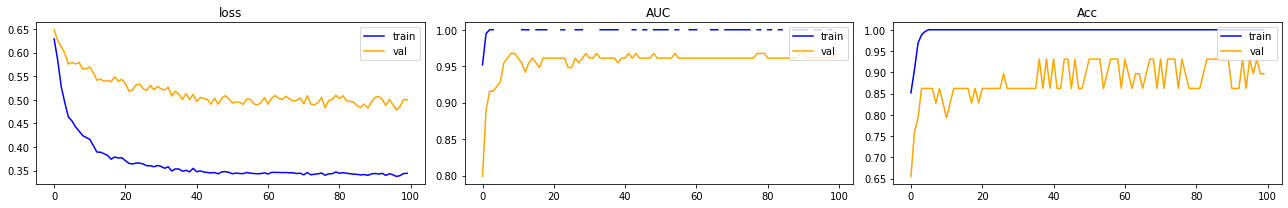

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))
axes[0].plot(train_losses[:,0], color='blue', label='train')
axes[0].plot(val_losses[:,0], color='orange', label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], color='blue', label='train')
axes[1].plot(val_losses[:,1], color='orange', label='val')
axes[1].set_title('AUC')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], color='blue', label='train')
axes[2].plot(val_losses[:,2], color='orange', label='val')
axes[2].set_title('Acc')
axes[2].legend(loc=1)
plt.tight_layout()

In [46]:
model.eval()
y_pred_lst = []
y_true_lst = []
for index, batch in enumerate(test_loader):
    batch_data, batch_labels = map(lambda x: cast(x, device), batch)
    batch_preds = model(batch_data)
    y_pred_lst.append(batch_preds)
    y_true_lst.append(batch_labels);

In [47]:
print('Test average AUC: {:.2f}'.format(roc_auc_score(flatten_for_auc(y_true_lst), flatten_for_auc(y_pred_lst))))
print('Test average Accuracy: {:.2f}'.format(accuracy_score(flatten_for_acc(y_true_lst), flatten_for_acc(y_pred_lst))))

Test average AUC: 0.90
Test average Accuracy: 0.83


In [ ]:
print(y_pred_lst)
print(y_true_lst)

[tensor([[0.9310, 0.0690],
        [0.7453, 0.2547],
        [0.8875, 0.1125],
        [0.8219, 0.1781],
        [0.2586, 0.7414],
        [0.2159, 0.7841],
        [0.8208, 0.1792],
        [0.4515, 0.5485],
        [0.7199, 0.2801],
        [0.8301, 0.1699],
        [0.9004, 0.0996],
        [0.9355, 0.0645],
        [0.7489, 0.2511],
        [0.8920, 0.1080],
        [0.7364, 0.2636],
        [0.7718, 0.2282],
        [0.4968, 0.5032],
        [0.4591, 0.5409],
        [0.8288, 0.1712],
        [0.8045, 0.1955],
        [0.8841, 0.1159],
        [0.8287, 0.1713],
        [0.9087, 0.0913],
        [0.8989, 0.1011],
        [0.3719, 0.6281],
        [0.8756, 0.1244],
        [0.9089, 0.0911],
        [0.6234, 0.3766],
        [0.9554, 0.0446]], device='cuda:0', grad_fn=<SoftmaxBackward0>)]
[tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],

Cross Validation

In [48]:
def CV_eval_loss(model, test_loader, device):
    model.eval()
    loss_total = 0
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    auc_meter = AverageMeter()
    
    for index, batch in enumerate(test_loader):
        batch_data, batch_labels = map(lambda x: cast(x, device), batch)
        y_true = batch_labels.cpu().detach().numpy()
        y_pred = model(batch_data).cpu().detach().numpy()
        loss = model.loss(batch_data, batch_labels)
        loss_meter.update(loss.item())
        auc = np.infty
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError as e:
            print('Only one class present in y_true. ROC AUC score is not defined in that case.')
        auc_meter.update(auc)
        acc = accuracy_score(y_true.argmax(1), y_pred.argmax(1))
        acc_meter.update(acc)
        
    return loss_meter.avg, auc_meter.avg, acc_meter.avg

In [49]:
def CV_train(model, train_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=30, gamma=0.1)
    best_eval = np.infty
    loss_meter = AverageMeter()

    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, batch in tenumerate(train_loader):
            batch_data, batch_labels = map(lambda x: cast(x, device), batch)

            model.optimizer.zero_grad()
            loss = model.loss(batch_data, batch_labels)

            if torch.isnan(loss):
                print("Numerical error, quiting...")
                return model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clip)
            model.optimizer.step()

            loss_meter.update(loss.item())

        scheduler.step()

        logger.info("In epochs {} | "
                    "total loss: {:5f}".format(
            epoch, loss_meter.avg
        ))

    print("Training done!")
    return model

In [50]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = Namespace(data_type=data_type, hid_dim = 128,
                   lr=1e-4, momentum=0.9, weight_decay=1e-6,
                   epochs=50, batch=32, opt='Adam', 
                   eval_epoch=1, drop_out=0.1, clip=1e7)

In [51]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 666)

fold = 0
cv_accs = []
cv_aucs = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(sorted_firing_rates, choices.argmax(1))):

    gc.collect()
    torch.cuda.empty_cache()

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold} ...')

    train_set = NeuralData(data_type=config.data_type, split="train", train_ids=train_idx, val_ids=None, test_ids=test_idx)
    test_set = NeuralData(data_type=config.data_type, split="test", train_ids=train_idx, val_ids=None, test_ids=test_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=32,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        batch_size=32,
        shuffle=False
    )

    model = Decoder(config, device)
    model.apply(reset_weights)
    model = CV_train(model, train_loader, config, logger, device)

    _, auc, acc = CV_eval_loss(model, test_loader, device)
    cv_accs.append(acc)
    cv_aucs.append(auc)
    print(f'Test accuracy: {acc} AUC: {auc}.')

print(f'Average {fold+1}-fold CV accuracy: {np.mean(cv_accs)} AUC: {np.mean(cv_aucs)}.')
print(f'SD of {fold+1}-fold CV accuracy: {np.std(cv_accs)} AUC: {np.std(cv_aucs)}.')

------------------------------------------------------------------------
Training for fold 0 ...
Reset trainable parameters of layer = Linear(in_features=15420, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:58,560 INFO In epochs 0 | total loss: 0.647486
INFO:batch32:In epochs 0 | total loss: 0.647486


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:58,650 INFO In epochs 1 | total loss: 0.556459
INFO:batch32:In epochs 1 | total loss: 0.556459


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:58,736 INFO In epochs 2 | total loss: 0.504485
INFO:batch32:In epochs 2 | total loss: 0.504485


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:58,818 INFO In epochs 3 | total loss: 0.472386
INFO:batch32:In epochs 3 | total loss: 0.472386


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:58,900 INFO In epochs 4 | total loss: 0.450922
INFO:batch32:In epochs 4 | total loss: 0.450922


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:58,992 INFO In epochs 5 | total loss: 0.437423
INFO:batch32:In epochs 5 | total loss: 0.437423


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,085 INFO In epochs 6 | total loss: 0.428942
INFO:batch32:In epochs 6 | total loss: 0.428942


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,176 INFO In epochs 7 | total loss: 0.421989
INFO:batch32:In epochs 7 | total loss: 0.421989


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,255 INFO In epochs 8 | total loss: 0.413975
INFO:batch32:In epochs 8 | total loss: 0.413975


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,346 INFO In epochs 9 | total loss: 0.407385
INFO:batch32:In epochs 9 | total loss: 0.407385


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,432 INFO In epochs 10 | total loss: 0.401863
INFO:batch32:In epochs 10 | total loss: 0.401863


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,524 INFO In epochs 11 | total loss: 0.397290
INFO:batch32:In epochs 11 | total loss: 0.397290


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,622 INFO In epochs 12 | total loss: 0.392952
INFO:batch32:In epochs 12 | total loss: 0.392952


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,718 INFO In epochs 13 | total loss: 0.390628
INFO:batch32:In epochs 13 | total loss: 0.390628


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,805 INFO In epochs 14 | total loss: 0.387211
INFO:batch32:In epochs 14 | total loss: 0.387211


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,894 INFO In epochs 15 | total loss: 0.384103
INFO:batch32:In epochs 15 | total loss: 0.384103


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:36:59,977 INFO In epochs 16 | total loss: 0.382912
INFO:batch32:In epochs 16 | total loss: 0.382912


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,064 INFO In epochs 17 | total loss: 0.380341
INFO:batch32:In epochs 17 | total loss: 0.380341


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,149 INFO In epochs 18 | total loss: 0.379123
INFO:batch32:In epochs 18 | total loss: 0.379123


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,238 INFO In epochs 19 | total loss: 0.377221
INFO:batch32:In epochs 19 | total loss: 0.377221


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,328 INFO In epochs 20 | total loss: 0.376218
INFO:batch32:In epochs 20 | total loss: 0.376218


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,419 INFO In epochs 21 | total loss: 0.374330
INFO:batch32:In epochs 21 | total loss: 0.374330


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,506 INFO In epochs 22 | total loss: 0.372766
INFO:batch32:In epochs 22 | total loss: 0.372766


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,605 INFO In epochs 23 | total loss: 0.371225
INFO:batch32:In epochs 23 | total loss: 0.371225


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,693 INFO In epochs 24 | total loss: 0.369789
INFO:batch32:In epochs 24 | total loss: 0.369789


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,789 INFO In epochs 25 | total loss: 0.368977
INFO:batch32:In epochs 25 | total loss: 0.368977


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,874 INFO In epochs 26 | total loss: 0.368109
INFO:batch32:In epochs 26 | total loss: 0.368109


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:00,972 INFO In epochs 27 | total loss: 0.367086
INFO:batch32:In epochs 27 | total loss: 0.367086


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,057 INFO In epochs 28 | total loss: 0.366423
INFO:batch32:In epochs 28 | total loss: 0.366423


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,152 INFO In epochs 29 | total loss: 0.365717
INFO:batch32:In epochs 29 | total loss: 0.365717


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,243 INFO In epochs 30 | total loss: 0.365101
INFO:batch32:In epochs 30 | total loss: 0.365101


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,337 INFO In epochs 31 | total loss: 0.364471
INFO:batch32:In epochs 31 | total loss: 0.364471


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,421 INFO In epochs 32 | total loss: 0.363966
INFO:batch32:In epochs 32 | total loss: 0.363966


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,520 INFO In epochs 33 | total loss: 0.363654
INFO:batch32:In epochs 33 | total loss: 0.363654


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,606 INFO In epochs 34 | total loss: 0.362765
INFO:batch32:In epochs 34 | total loss: 0.362765


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,711 INFO In epochs 35 | total loss: 0.362101
INFO:batch32:In epochs 35 | total loss: 0.362101


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,796 INFO In epochs 36 | total loss: 0.362183
INFO:batch32:In epochs 36 | total loss: 0.362183


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,891 INFO In epochs 37 | total loss: 0.361440
INFO:batch32:In epochs 37 | total loss: 0.361440


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:01,987 INFO In epochs 38 | total loss: 0.360700
INFO:batch32:In epochs 38 | total loss: 0.360700


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,085 INFO In epochs 39 | total loss: 0.359974
INFO:batch32:In epochs 39 | total loss: 0.359974


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,175 INFO In epochs 40 | total loss: 0.359285
INFO:batch32:In epochs 40 | total loss: 0.359285


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,271 INFO In epochs 41 | total loss: 0.358628
INFO:batch32:In epochs 41 | total loss: 0.358628


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,356 INFO In epochs 42 | total loss: 0.358019
INFO:batch32:In epochs 42 | total loss: 0.358019


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,450 INFO In epochs 43 | total loss: 0.357453
INFO:batch32:In epochs 43 | total loss: 0.357453


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,538 INFO In epochs 44 | total loss: 0.356953
INFO:batch32:In epochs 44 | total loss: 0.356953


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,630 INFO In epochs 45 | total loss: 0.356357
INFO:batch32:In epochs 45 | total loss: 0.356357


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,750 INFO In epochs 46 | total loss: 0.355814
INFO:batch32:In epochs 46 | total loss: 0.355814


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,844 INFO In epochs 47 | total loss: 0.355270
INFO:batch32:In epochs 47 | total loss: 0.355270


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:02,930 INFO In epochs 48 | total loss: 0.354993
INFO:batch32:In epochs 48 | total loss: 0.354993


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,023 INFO In epochs 49 | total loss: 0.354526
INFO:batch32:In epochs 49 | total loss: 0.354526


Training done!
Test accuracy: 0.9182692307692308 AUC: 0.9055639097744361.
------------------------------------------------------------------------
Training for fold 1 ...
Reset trainable parameters of layer = Linear(in_features=15420, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,295 INFO In epochs 0 | total loss: 0.713893
INFO:batch32:In epochs 0 | total loss: 0.713893


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,405 INFO In epochs 1 | total loss: 0.621827
INFO:batch32:In epochs 1 | total loss: 0.621827


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,496 INFO In epochs 2 | total loss: 0.563482
INFO:batch32:In epochs 2 | total loss: 0.563482


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,584 INFO In epochs 3 | total loss: 0.528480
INFO:batch32:In epochs 3 | total loss: 0.528480


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,677 INFO In epochs 4 | total loss: 0.500364
INFO:batch32:In epochs 4 | total loss: 0.500364


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,771 INFO In epochs 5 | total loss: 0.480539
INFO:batch32:In epochs 5 | total loss: 0.480539


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,862 INFO In epochs 6 | total loss: 0.465818
INFO:batch32:In epochs 6 | total loss: 0.465818


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:03,951 INFO In epochs 7 | total loss: 0.453413
INFO:batch32:In epochs 7 | total loss: 0.453413


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,038 INFO In epochs 8 | total loss: 0.443721
INFO:batch32:In epochs 8 | total loss: 0.443721


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,144 INFO In epochs 9 | total loss: 0.435283
INFO:batch32:In epochs 9 | total loss: 0.435283


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,241 INFO In epochs 10 | total loss: 0.429015
INFO:batch32:In epochs 10 | total loss: 0.429015


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,330 INFO In epochs 11 | total loss: 0.425378
INFO:batch32:In epochs 11 | total loss: 0.425378


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,422 INFO In epochs 12 | total loss: 0.420165
INFO:batch32:In epochs 12 | total loss: 0.420165


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,510 INFO In epochs 13 | total loss: 0.417599
INFO:batch32:In epochs 13 | total loss: 0.417599


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,601 INFO In epochs 14 | total loss: 0.413437
INFO:batch32:In epochs 14 | total loss: 0.413437


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,691 INFO In epochs 15 | total loss: 0.411396
INFO:batch32:In epochs 15 | total loss: 0.411396


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,789 INFO In epochs 16 | total loss: 0.409473
INFO:batch32:In epochs 16 | total loss: 0.409473


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,881 INFO In epochs 17 | total loss: 0.407515
INFO:batch32:In epochs 17 | total loss: 0.407515


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:04,988 INFO In epochs 18 | total loss: 0.405671
INFO:batch32:In epochs 18 | total loss: 0.405671


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,074 INFO In epochs 19 | total loss: 0.403018
INFO:batch32:In epochs 19 | total loss: 0.403018


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,174 INFO In epochs 20 | total loss: 0.400543
INFO:batch32:In epochs 20 | total loss: 0.400543


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,258 INFO In epochs 21 | total loss: 0.399080
INFO:batch32:In epochs 21 | total loss: 0.399080


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,359 INFO In epochs 22 | total loss: 0.397794
INFO:batch32:In epochs 22 | total loss: 0.397794


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,450 INFO In epochs 23 | total loss: 0.395731
INFO:batch32:In epochs 23 | total loss: 0.395731


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,539 INFO In epochs 24 | total loss: 0.393674
INFO:batch32:In epochs 24 | total loss: 0.393674


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,627 INFO In epochs 25 | total loss: 0.391794
INFO:batch32:In epochs 25 | total loss: 0.391794


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,719 INFO In epochs 26 | total loss: 0.390025
INFO:batch32:In epochs 26 | total loss: 0.390025


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,820 INFO In epochs 27 | total loss: 0.388215
INFO:batch32:In epochs 27 | total loss: 0.388215


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,911 INFO In epochs 28 | total loss: 0.386515
INFO:batch32:In epochs 28 | total loss: 0.386515


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:05,999 INFO In epochs 29 | total loss: 0.384935
INFO:batch32:In epochs 29 | total loss: 0.384935


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,090 INFO In epochs 30 | total loss: 0.383462
INFO:batch32:In epochs 30 | total loss: 0.383462


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,177 INFO In epochs 31 | total loss: 0.382101
INFO:batch32:In epochs 31 | total loss: 0.382101


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,267 INFO In epochs 32 | total loss: 0.380850
INFO:batch32:In epochs 32 | total loss: 0.380850


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,359 INFO In epochs 33 | total loss: 0.380072
INFO:batch32:In epochs 33 | total loss: 0.380072


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,449 INFO In epochs 34 | total loss: 0.378843
INFO:batch32:In epochs 34 | total loss: 0.378843


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,537 INFO In epochs 35 | total loss: 0.377906
INFO:batch32:In epochs 35 | total loss: 0.377906


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,627 INFO In epochs 36 | total loss: 0.377236
INFO:batch32:In epochs 36 | total loss: 0.377236


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,716 INFO In epochs 37 | total loss: 0.376696
INFO:batch32:In epochs 37 | total loss: 0.376696


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,808 INFO In epochs 38 | total loss: 0.375667
INFO:batch32:In epochs 38 | total loss: 0.375667


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,902 INFO In epochs 39 | total loss: 0.374725
INFO:batch32:In epochs 39 | total loss: 0.374725


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:06,989 INFO In epochs 40 | total loss: 0.373845
INFO:batch32:In epochs 40 | total loss: 0.373845


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,069 INFO In epochs 41 | total loss: 0.372960
INFO:batch32:In epochs 41 | total loss: 0.372960


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,153 INFO In epochs 42 | total loss: 0.372119
INFO:batch32:In epochs 42 | total loss: 0.372119


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,239 INFO In epochs 43 | total loss: 0.371756
INFO:batch32:In epochs 43 | total loss: 0.371756


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,324 INFO In epochs 44 | total loss: 0.370978
INFO:batch32:In epochs 44 | total loss: 0.370978


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,406 INFO In epochs 45 | total loss: 0.370212
INFO:batch32:In epochs 45 | total loss: 0.370212


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,491 INFO In epochs 46 | total loss: 0.369846
INFO:batch32:In epochs 46 | total loss: 0.369846


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,580 INFO In epochs 47 | total loss: 0.369454
INFO:batch32:In epochs 47 | total loss: 0.369454


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,669 INFO In epochs 48 | total loss: 0.368772
INFO:batch32:In epochs 48 | total loss: 0.368772


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:07,750 INFO In epochs 49 | total loss: 0.368116
INFO:batch32:In epochs 49 | total loss: 0.368116


Training done!
Test accuracy: 0.9375 AUC: 0.96875.
------------------------------------------------------------------------
Training for fold 2 ...
Reset trainable parameters of layer = Linear(in_features=15420, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,048 INFO In epochs 0 | total loss: 0.735842
INFO:batch32:In epochs 0 | total loss: 0.735842


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,139 INFO In epochs 1 | total loss: 0.633867
INFO:batch32:In epochs 1 | total loss: 0.633867


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,223 INFO In epochs 2 | total loss: 0.586977
INFO:batch32:In epochs 2 | total loss: 0.586977


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,309 INFO In epochs 3 | total loss: 0.544594
INFO:batch32:In epochs 3 | total loss: 0.544594


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,389 INFO In epochs 4 | total loss: 0.522319
INFO:batch32:In epochs 4 | total loss: 0.522319


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,474 INFO In epochs 5 | total loss: 0.506718
INFO:batch32:In epochs 5 | total loss: 0.506718


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,558 INFO In epochs 6 | total loss: 0.494003
INFO:batch32:In epochs 6 | total loss: 0.494003


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,642 INFO In epochs 7 | total loss: 0.479960
INFO:batch32:In epochs 7 | total loss: 0.479960


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,728 INFO In epochs 8 | total loss: 0.471944
INFO:batch32:In epochs 8 | total loss: 0.471944


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,812 INFO In epochs 9 | total loss: 0.461169
INFO:batch32:In epochs 9 | total loss: 0.461169


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,903 INFO In epochs 10 | total loss: 0.453033
INFO:batch32:In epochs 10 | total loss: 0.453033


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:08,995 INFO In epochs 11 | total loss: 0.447944
INFO:batch32:In epochs 11 | total loss: 0.447944


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,080 INFO In epochs 12 | total loss: 0.442181
INFO:batch32:In epochs 12 | total loss: 0.442181


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,161 INFO In epochs 13 | total loss: 0.436379
INFO:batch32:In epochs 13 | total loss: 0.436379


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,251 INFO In epochs 14 | total loss: 0.432964
INFO:batch32:In epochs 14 | total loss: 0.432964


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,336 INFO In epochs 15 | total loss: 0.428072
INFO:batch32:In epochs 15 | total loss: 0.428072


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,424 INFO In epochs 16 | total loss: 0.423766
INFO:batch32:In epochs 16 | total loss: 0.423766


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,556 INFO In epochs 17 | total loss: 0.421755
INFO:batch32:In epochs 17 | total loss: 0.421755


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,684 INFO In epochs 18 | total loss: 0.419856
INFO:batch32:In epochs 18 | total loss: 0.419856


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,771 INFO In epochs 19 | total loss: 0.418221
INFO:batch32:In epochs 19 | total loss: 0.418221


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:09,854 INFO In epochs 20 | total loss: 0.415012
INFO:batch32:In epochs 20 | total loss: 0.415012


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:10,063 INFO In epochs 21 | total loss: 0.412141
INFO:batch32:In epochs 21 | total loss: 0.412141


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:10,244 INFO In epochs 22 | total loss: 0.410536
INFO:batch32:In epochs 22 | total loss: 0.410536


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:10,423 INFO In epochs 23 | total loss: 0.408763
INFO:batch32:In epochs 23 | total loss: 0.408763


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:10,594 INFO In epochs 24 | total loss: 0.406260
INFO:batch32:In epochs 24 | total loss: 0.406260


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:10,788 INFO In epochs 25 | total loss: 0.404117
INFO:batch32:In epochs 25 | total loss: 0.404117


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:11,007 INFO In epochs 26 | total loss: 0.401878
INFO:batch32:In epochs 26 | total loss: 0.401878


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:11,262 INFO In epochs 27 | total loss: 0.399730
INFO:batch32:In epochs 27 | total loss: 0.399730


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:11,459 INFO In epochs 28 | total loss: 0.397799
INFO:batch32:In epochs 28 | total loss: 0.397799


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:11,575 INFO In epochs 29 | total loss: 0.395941
INFO:batch32:In epochs 29 | total loss: 0.395941


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:11,679 INFO In epochs 30 | total loss: 0.394187
INFO:batch32:In epochs 30 | total loss: 0.394187


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:11,882 INFO In epochs 31 | total loss: 0.392500
INFO:batch32:In epochs 31 | total loss: 0.392500


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:12,115 INFO In epochs 32 | total loss: 0.390861
INFO:batch32:In epochs 32 | total loss: 0.390861


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:12,335 INFO In epochs 33 | total loss: 0.389333
INFO:batch32:In epochs 33 | total loss: 0.389333


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:12,516 INFO In epochs 34 | total loss: 0.387845
INFO:batch32:In epochs 34 | total loss: 0.387845


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:12,718 INFO In epochs 35 | total loss: 0.386470
INFO:batch32:In epochs 35 | total loss: 0.386470


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:12,911 INFO In epochs 36 | total loss: 0.385937
INFO:batch32:In epochs 36 | total loss: 0.385937


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:13,093 INFO In epochs 37 | total loss: 0.384701
INFO:batch32:In epochs 37 | total loss: 0.384701


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:13,317 INFO In epochs 38 | total loss: 0.384006
INFO:batch32:In epochs 38 | total loss: 0.384006


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:13,484 INFO In epochs 39 | total loss: 0.382891
INFO:batch32:In epochs 39 | total loss: 0.382891


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:13,648 INFO In epochs 40 | total loss: 0.381836
INFO:batch32:In epochs 40 | total loss: 0.381836


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:13,827 INFO In epochs 41 | total loss: 0.381415
INFO:batch32:In epochs 41 | total loss: 0.381415


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,022 INFO In epochs 42 | total loss: 0.380949
INFO:batch32:In epochs 42 | total loss: 0.380949


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,136 INFO In epochs 43 | total loss: 0.379927
INFO:batch32:In epochs 43 | total loss: 0.379927


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,240 INFO In epochs 44 | total loss: 0.378998
INFO:batch32:In epochs 44 | total loss: 0.378998


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,340 INFO In epochs 45 | total loss: 0.378111
INFO:batch32:In epochs 45 | total loss: 0.378111


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,427 INFO In epochs 46 | total loss: 0.377335
INFO:batch32:In epochs 46 | total loss: 0.377335


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,508 INFO In epochs 47 | total loss: 0.376594
INFO:batch32:In epochs 47 | total loss: 0.376594


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,595 INFO In epochs 48 | total loss: 0.376166
INFO:batch32:In epochs 48 | total loss: 0.376166


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,688 INFO In epochs 49 | total loss: 0.375406
INFO:batch32:In epochs 49 | total loss: 0.375406


Training done!
Test accuracy: 0.90875 AUC: 0.9658119658119658.
------------------------------------------------------------------------
Training for fold 3 ...
Reset trainable parameters of layer = Linear(in_features=15420, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:14,987 INFO In epochs 0 | total loss: 0.676740
INFO:batch32:In epochs 0 | total loss: 0.676740


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,077 INFO In epochs 1 | total loss: 0.563781
INFO:batch32:In epochs 1 | total loss: 0.563781


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,163 INFO In epochs 2 | total loss: 0.518556
INFO:batch32:In epochs 2 | total loss: 0.518556


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,251 INFO In epochs 3 | total loss: 0.483076
INFO:batch32:In epochs 3 | total loss: 0.483076


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,369 INFO In epochs 4 | total loss: 0.460514
INFO:batch32:In epochs 4 | total loss: 0.460514


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,470 INFO In epochs 5 | total loss: 0.444556
INFO:batch32:In epochs 5 | total loss: 0.444556


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,581 INFO In epochs 6 | total loss: 0.436019
INFO:batch32:In epochs 6 | total loss: 0.436019


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,683 INFO In epochs 7 | total loss: 0.425688
INFO:batch32:In epochs 7 | total loss: 0.425688


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,771 INFO In epochs 8 | total loss: 0.420716
INFO:batch32:In epochs 8 | total loss: 0.420716


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,856 INFO In epochs 9 | total loss: 0.413238
INFO:batch32:In epochs 9 | total loss: 0.413238


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:15,946 INFO In epochs 10 | total loss: 0.409661
INFO:batch32:In epochs 10 | total loss: 0.409661


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,055 INFO In epochs 11 | total loss: 0.404093
INFO:batch32:In epochs 11 | total loss: 0.404093


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,156 INFO In epochs 12 | total loss: 0.399450
INFO:batch32:In epochs 12 | total loss: 0.399450


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,256 INFO In epochs 13 | total loss: 0.397257
INFO:batch32:In epochs 13 | total loss: 0.397257


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,361 INFO In epochs 14 | total loss: 0.393530
INFO:batch32:In epochs 14 | total loss: 0.393530


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,453 INFO In epochs 15 | total loss: 0.390355
INFO:batch32:In epochs 15 | total loss: 0.390355


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,543 INFO In epochs 16 | total loss: 0.387235
INFO:batch32:In epochs 16 | total loss: 0.387235


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,645 INFO In epochs 17 | total loss: 0.384593
INFO:batch32:In epochs 17 | total loss: 0.384593


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,748 INFO In epochs 18 | total loss: 0.382124
INFO:batch32:In epochs 18 | total loss: 0.382124


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,858 INFO In epochs 19 | total loss: 0.379868
INFO:batch32:In epochs 19 | total loss: 0.379868


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:16,959 INFO In epochs 20 | total loss: 0.377606
INFO:batch32:In epochs 20 | total loss: 0.377606


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,079 INFO In epochs 21 | total loss: 0.375695
INFO:batch32:In epochs 21 | total loss: 0.375695


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,193 INFO In epochs 22 | total loss: 0.373804
INFO:batch32:In epochs 22 | total loss: 0.373804


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,302 INFO In epochs 23 | total loss: 0.372021
INFO:batch32:In epochs 23 | total loss: 0.372021


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,402 INFO In epochs 24 | total loss: 0.371005
INFO:batch32:In epochs 24 | total loss: 0.371005


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,510 INFO In epochs 25 | total loss: 0.369512
INFO:batch32:In epochs 25 | total loss: 0.369512


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,610 INFO In epochs 26 | total loss: 0.368197
INFO:batch32:In epochs 26 | total loss: 0.368197


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,716 INFO In epochs 27 | total loss: 0.367033
INFO:batch32:In epochs 27 | total loss: 0.367033


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,813 INFO In epochs 28 | total loss: 0.366303
INFO:batch32:In epochs 28 | total loss: 0.366303


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:17,910 INFO In epochs 29 | total loss: 0.365134
INFO:batch32:In epochs 29 | total loss: 0.365134


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,021 INFO In epochs 30 | total loss: 0.364111
INFO:batch32:In epochs 30 | total loss: 0.364111


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,119 INFO In epochs 31 | total loss: 0.363970
INFO:batch32:In epochs 31 | total loss: 0.363970


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,204 INFO In epochs 32 | total loss: 0.363552
INFO:batch32:In epochs 32 | total loss: 0.363552


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,294 INFO In epochs 33 | total loss: 0.362612
INFO:batch32:In epochs 33 | total loss: 0.362612


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,383 INFO In epochs 34 | total loss: 0.361726
INFO:batch32:In epochs 34 | total loss: 0.361726


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,480 INFO In epochs 35 | total loss: 0.360990
INFO:batch32:In epochs 35 | total loss: 0.360990


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,568 INFO In epochs 36 | total loss: 0.360205
INFO:batch32:In epochs 36 | total loss: 0.360205


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,666 INFO In epochs 37 | total loss: 0.359443
INFO:batch32:In epochs 37 | total loss: 0.359443


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,777 INFO In epochs 38 | total loss: 0.359148
INFO:batch32:In epochs 38 | total loss: 0.359148


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,867 INFO In epochs 39 | total loss: 0.358455
INFO:batch32:In epochs 39 | total loss: 0.358455


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:18,970 INFO In epochs 40 | total loss: 0.358378
INFO:batch32:In epochs 40 | total loss: 0.358378


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,056 INFO In epochs 41 | total loss: 0.357938
INFO:batch32:In epochs 41 | total loss: 0.357938


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,136 INFO In epochs 42 | total loss: 0.357230
INFO:batch32:In epochs 42 | total loss: 0.357230


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,236 INFO In epochs 43 | total loss: 0.356586
INFO:batch32:In epochs 43 | total loss: 0.356586


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,327 INFO In epochs 44 | total loss: 0.355978
INFO:batch32:In epochs 44 | total loss: 0.355978


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,435 INFO In epochs 45 | total loss: 0.355812
INFO:batch32:In epochs 45 | total loss: 0.355812


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,528 INFO In epochs 46 | total loss: 0.355337
INFO:batch32:In epochs 46 | total loss: 0.355337


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,615 INFO In epochs 47 | total loss: 0.354786
INFO:batch32:In epochs 47 | total loss: 0.354786


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,708 INFO In epochs 48 | total loss: 0.354251
INFO:batch32:In epochs 48 | total loss: 0.354251


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:19,801 INFO In epochs 49 | total loss: 0.354105
INFO:batch32:In epochs 49 | total loss: 0.354105


Training done!
Test accuracy: 0.8975 AUC: 0.948125.
------------------------------------------------------------------------
Training for fold 4 ...
Reset trainable parameters of layer = Linear(in_features=15420, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=2, bias=True)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,137 INFO In epochs 0 | total loss: 0.614220
INFO:batch32:In epochs 0 | total loss: 0.614220


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,237 INFO In epochs 1 | total loss: 0.522431
INFO:batch32:In epochs 1 | total loss: 0.522431


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,334 INFO In epochs 2 | total loss: 0.477393
INFO:batch32:In epochs 2 | total loss: 0.477393


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,436 INFO In epochs 3 | total loss: 0.456600
INFO:batch32:In epochs 3 | total loss: 0.456600


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,533 INFO In epochs 4 | total loss: 0.443507
INFO:batch32:In epochs 4 | total loss: 0.443507


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,618 INFO In epochs 5 | total loss: 0.428464
INFO:batch32:In epochs 5 | total loss: 0.428464


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,717 INFO In epochs 6 | total loss: 0.418399
INFO:batch32:In epochs 6 | total loss: 0.418399


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,808 INFO In epochs 7 | total loss: 0.409887
INFO:batch32:In epochs 7 | total loss: 0.409887


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,892 INFO In epochs 8 | total loss: 0.403223
INFO:batch32:In epochs 8 | total loss: 0.403223


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:20,973 INFO In epochs 9 | total loss: 0.397164
INFO:batch32:In epochs 9 | total loss: 0.397164


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,058 INFO In epochs 10 | total loss: 0.394109
INFO:batch32:In epochs 10 | total loss: 0.394109


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,141 INFO In epochs 11 | total loss: 0.389653
INFO:batch32:In epochs 11 | total loss: 0.389653


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,225 INFO In epochs 12 | total loss: 0.385875
INFO:batch32:In epochs 12 | total loss: 0.385875


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,306 INFO In epochs 13 | total loss: 0.382633
INFO:batch32:In epochs 13 | total loss: 0.382633


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,388 INFO In epochs 14 | total loss: 0.379652
INFO:batch32:In epochs 14 | total loss: 0.379652


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,491 INFO In epochs 15 | total loss: 0.376856
INFO:batch32:In epochs 15 | total loss: 0.376856


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,577 INFO In epochs 16 | total loss: 0.375371
INFO:batch32:In epochs 16 | total loss: 0.375371


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,662 INFO In epochs 17 | total loss: 0.373229
INFO:batch32:In epochs 17 | total loss: 0.373229


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,753 INFO In epochs 18 | total loss: 0.371221
INFO:batch32:In epochs 18 | total loss: 0.371221


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,833 INFO In epochs 19 | total loss: 0.370020
INFO:batch32:In epochs 19 | total loss: 0.370020


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:21,926 INFO In epochs 20 | total loss: 0.368287
INFO:batch32:In epochs 20 | total loss: 0.368287


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,008 INFO In epochs 21 | total loss: 0.366626
INFO:batch32:In epochs 21 | total loss: 0.366626


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,092 INFO In epochs 22 | total loss: 0.365734
INFO:batch32:In epochs 22 | total loss: 0.365734


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,173 INFO In epochs 23 | total loss: 0.364921
INFO:batch32:In epochs 23 | total loss: 0.364921


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,256 INFO In epochs 24 | total loss: 0.363657
INFO:batch32:In epochs 24 | total loss: 0.363657


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,335 INFO In epochs 25 | total loss: 0.362456
INFO:batch32:In epochs 25 | total loss: 0.362456


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,422 INFO In epochs 26 | total loss: 0.361407
INFO:batch32:In epochs 26 | total loss: 0.361407


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,522 INFO In epochs 27 | total loss: 0.360765
INFO:batch32:In epochs 27 | total loss: 0.360765


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,606 INFO In epochs 28 | total loss: 0.360257
INFO:batch32:In epochs 28 | total loss: 0.360257


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,701 INFO In epochs 29 | total loss: 0.359644
INFO:batch32:In epochs 29 | total loss: 0.359644


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,784 INFO In epochs 30 | total loss: 0.358752
INFO:batch32:In epochs 30 | total loss: 0.358752


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,870 INFO In epochs 31 | total loss: 0.357830
INFO:batch32:In epochs 31 | total loss: 0.357830


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:22,994 INFO In epochs 32 | total loss: 0.357055
INFO:batch32:In epochs 32 | total loss: 0.357055


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,091 INFO In epochs 33 | total loss: 0.356510
INFO:batch32:In epochs 33 | total loss: 0.356510


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,192 INFO In epochs 34 | total loss: 0.355718
INFO:batch32:In epochs 34 | total loss: 0.355718


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,287 INFO In epochs 35 | total loss: 0.355324
INFO:batch32:In epochs 35 | total loss: 0.355324


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,381 INFO In epochs 36 | total loss: 0.354958
INFO:batch32:In epochs 36 | total loss: 0.354958


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,478 INFO In epochs 37 | total loss: 0.354721
INFO:batch32:In epochs 37 | total loss: 0.354721


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,577 INFO In epochs 38 | total loss: 0.354045
INFO:batch32:In epochs 38 | total loss: 0.354045


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,682 INFO In epochs 39 | total loss: 0.353732
INFO:batch32:In epochs 39 | total loss: 0.353732


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,799 INFO In epochs 40 | total loss: 0.353294
INFO:batch32:In epochs 40 | total loss: 0.353294


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,902 INFO In epochs 41 | total loss: 0.352736
INFO:batch32:In epochs 41 | total loss: 0.352736


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:23,994 INFO In epochs 42 | total loss: 0.352279
INFO:batch32:In epochs 42 | total loss: 0.352279


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,091 INFO In epochs 43 | total loss: 0.352063
INFO:batch32:In epochs 43 | total loss: 0.352063


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,185 INFO In epochs 44 | total loss: 0.351784
INFO:batch32:In epochs 44 | total loss: 0.351784


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,285 INFO In epochs 45 | total loss: 0.351331
INFO:batch32:In epochs 45 | total loss: 0.351331


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,382 INFO In epochs 46 | total loss: 0.350855
INFO:batch32:In epochs 46 | total loss: 0.350855


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,485 INFO In epochs 47 | total loss: 0.350420
INFO:batch32:In epochs 47 | total loss: 0.350420


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,595 INFO In epochs 48 | total loss: 0.349958
INFO:batch32:In epochs 48 | total loss: 0.349958


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-04 19:37:24,688 INFO In epochs 49 | total loss: 0.349526
INFO:batch32:In epochs 49 | total loss: 0.349526


Training done!
Test accuracy: 0.86625 AUC: 0.9795548654244307.
Average 5-fold CV accuracy: 0.9056538461538463 AUC: 0.9535611482021666.
SD of 5-fold CV accuracy: 0.023673022245765785 AUC: 0.026037448761506838.
